In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [3]:
df = pd.read_parquet('cleaned/netflix_parquet')

In [4]:
# look at dataframe, first row and the dictionaries created during joining and merging the netflix prize dataset
df
df.iloc[0]
df['review_data'].iloc[0]

,movieId,year,title,review_data
0,1,2003,Dinosaur Planet,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':..."
1,2,2004,Isle of Man TT 2004 Review,"[{'date': 2005-09-05, 'rating': 4.0, 'userId':..."
2,3,1997,Character,"[{'date': 2003-03-29, 'rating': 4.0, 'userId':..."
3,4,1994,Paula Abdul's Get Up & Dance,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':..."
4,5,2004,The Rise and Fall of ECW,"[{'date': 2005-02-08, 'rating': 5.0, 'userId':..."
...,...,...,...,...
1428,13669,1988,Red Dwarf: Series 4,"[{'date': 2005-07-07, 'rating': 4.0, 'userId':..."
1429,13670,1997,White Badge,"[{'date': 2002-09-04, 'rating': 1.0, 'userId':..."
1430,13671,1967,Samurai Rebellion,"[{'date': 2005-11-28, 'rating': 4.0, 'userId':..."
1431,13672,1973,Kung Fu: Season 2,"[{'date': 2005-07-07, 'rating': 5.0, 'userId':..."


movieId                                                        1
year                                                        2003
title                                            Dinosaur Planet
review_data    [{'date': 2005-09-06, 'rating': 3.0, 'userId':...
Name: 0, dtype: object

array([{'date': datetime.date(2005, 9, 6), 'rating': 3.0, 'userId': '1488844'},
       {'date': datetime.date(2005, 5, 13), 'rating': 5.0, 'userId': '822109'},
       {'date': datetime.date(2005, 10, 19), 'rating': 4.0, 'userId': '885013'},
       {'date': datetime.date(2005, 12, 26), 'rating': 4.0, 'userId': '30878'},
       {'date': datetime.date(2004, 5, 3), 'rating': 3.0, 'userId': '823519'},
       {'date': datetime.date(2005, 11, 17), 'rating': 3.0, 'userId': '893988'},
       {'date': datetime.date(2004, 8, 5), 'rating': 4.0, 'userId': '124105'},
       {'date': datetime.date(2004, 4, 22), 'rating': 3.0, 'userId': '1248029'},
       {'date': datetime.date(2004, 5, 9), 'rating': 4.0, 'userId': '1842128'},
       {'date': datetime.date(2005, 5, 11), 'rating': 3.0, 'userId': '2238063'},
       {'date': datetime.date(2005, 5, 19), 'rating': 4.0, 'userId': '1503895'},
       {'date': datetime.date(2005, 6, 6), 'rating': 5.0, 'userId': '2207774'},
       {'date': datetime.date(2004, 8

So the dataset consists off the id, title, release year and corresponding reviews, where the userId, rating and date are appended in dictionaries. 

### Some general findings about Netflix Prize dataframe:

In [5]:
unique_users = set()  # Using a set to store unique user IDs

# Iterate over each row
for index, row in df.iterrows():
    # Iterate over each dictionary in the 'review_data' column of the current row
    for review_entry in row['review_data']:
        user_id = review_entry.get('userId')  # Extracting 'userId' from the dictionary
        if user_id:  # Check if 'userId' exists in the dictionary
            unique_users.add(user_id)  # Add 'userId' to the set of unique user IDs

amount_of_reviews = list()  # Using a set to store unique user IDs

# Iterate over each row
for index, row in df.iterrows():
    # Iterate over each dictionary in the 'review_data' column of the current row
    for review_entry in row['review_data']:
        user_id = review_entry.get('userId')  # Extracting 'userId' from the dictionary
        if user_id:  # Check if 'userId' exists in the dictionary
            amount_of_reviews.append(user_id)  # Add 'userId' to the set of unique user IDs

print("There are {} reviews in our dataframe.".format(len(amount_of_reviews)))
print("There are {} unique users who have reviewed a movie.".format(len(unique_users)))

There are 7998567 reviews in our dataframe.
There are 449424 unique users who have reviewed a movie.


The complete dataset is handled above, from now on we will work with samples, to test whether the sample size is representative of the entire dataset.
## Let's look into the columns more deeply:
### When were the most movies released?

In [6]:
# exclude anything other than numbers in the year column
df = df[df['year'].str.isdigit()]

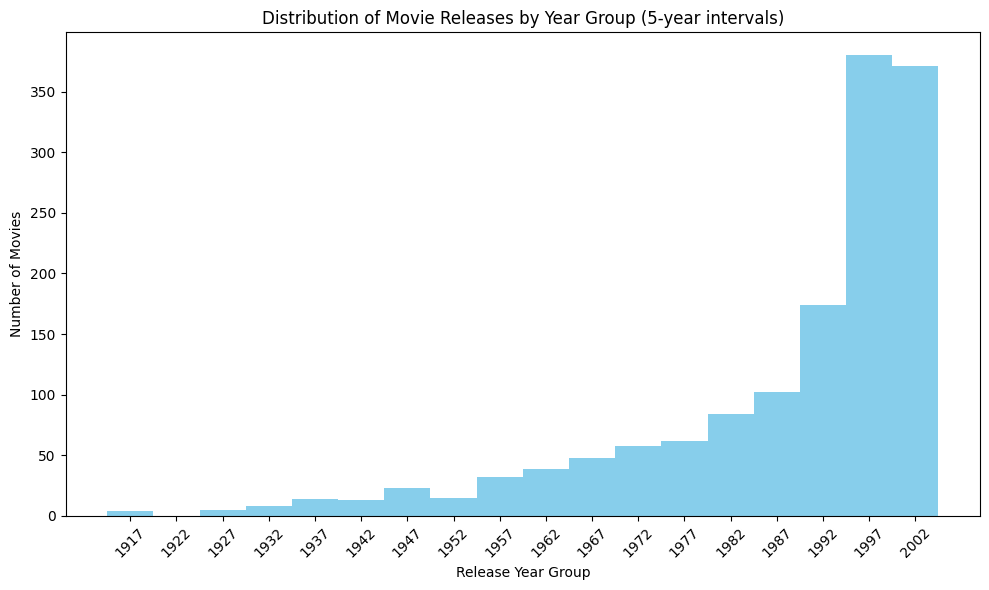

In [7]:
# Define the bin size in years
bin_size = 5

# Extract release years from the 'release_year' column
release_years = (df['year'].astype(int)).tolist()

# Calculate the minimum and maximum release years to determine the range
min_year = min(release_years)
max_year = max(release_years)

# Initialize dictionary to store counts for each bin
bin_counts = {}

# Count the occurrences of each release year within the corresponding bin
for year in release_years:
    bin_index = (year - min_year) // bin_size
    bin_start_year = min_year + bin_index * bin_size
    if bin_start_year in bin_counts:
        bin_counts[bin_start_year] += 1
    else:
        bin_counts[bin_start_year] = 1

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(bin_counts.keys(), bin_counts.values(), color='skyblue', width=bin_size)
plt.xlabel('Release Year Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Releases by Year Group ({}-year intervals)'.format(bin_size))
plt.xticks(range(min_year, max_year + 1, bin_size), rotation=45)
plt.tight_layout()
plt.show(); # to dont export text output

Seems like most movies have been released around the 90s and the 00s in the dataset.

### When were the most ratings placed?

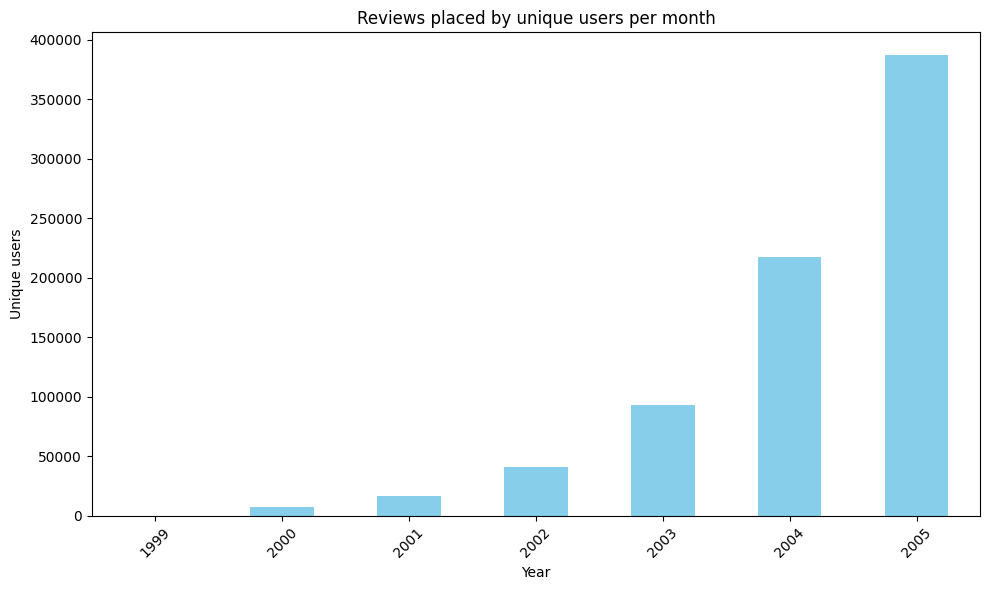

In [8]:
# Extract review dates and user IDs using NumPy
review_data = df['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Create a DataFrame with review dates and user IDs
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids})

# Group reviews by month and count the number of unique users for each month
yearly_unique_users = review_df.groupby(review_df['Date'].dt.to_period('Y'))['User_ID'].nunique()

# Plot the number of unique users by month
plt.figure(figsize=(10, 6))
yearly_unique_users.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unique users')
plt.title('Reviews placed by unique users per month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

In 2005, most movies were reviewed by unique users.

### On which days of the week most reviews were placed?

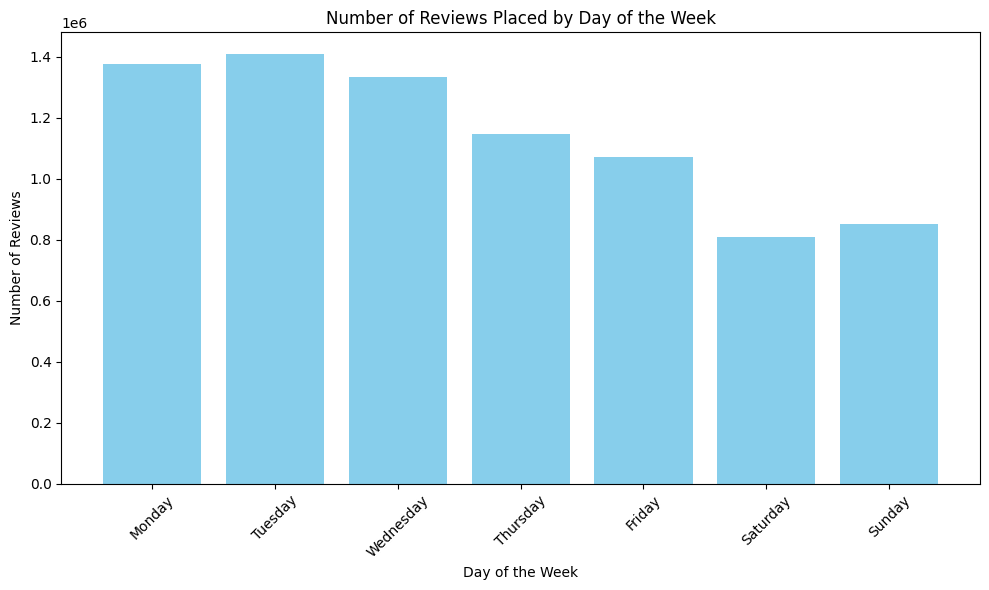

In [9]:
# Get the weekday (0: Monday, 1: Tuesday, ..., 6: Sunday)
weekdays = review_df['Date'].dt.dayofweek

# Count the occurrences of each weekday
weekday_counts = np.bincount(weekdays)

# Plot the distribution of reviews by day of the week
plt.figure(figsize=(10, 6))
plt.bar(range(7), weekday_counts, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Placed by Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.tight_layout()
plt.show();

Most reviews were made on Tuesdays.

### Which movie has the highest average rating?

In [10]:
# extract review dates, user IDs, and ratings using NumPy
review_data = df['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])
ratings = np.concatenate([np.array([entry['rating'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Extract movie titles
titles = np.concatenate([[title] * len(row) for title, row in zip(df['title'], review_data)])

# Create a DataFrame with review dates, user IDs, ratings, and movie titles
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids, 'Rating': ratings, 'Movie_Title': titles})

In [11]:
review_df.groupby('Movie_Title')['Rating'].mean().sort_values(ascending=False).head(10)
print('{} is the best rated movie on average in this dataset.'.format(review_df.groupby('Movie_Title')['Rating'].mean().idxmax()))

Movie_Title
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material    4.552000
House, M.D.: Season 1                                                          4.522613
Star Wars: Episode VI: Return of the Jedi                                      4.462201
Full Metal Panic FUMOFFU                                                       4.451456
The West Wing: Season 2                                                        4.449001
Stargate SG-1: Season 5                                                        4.389232
As Time Goes By: Series 9                                                      4.376682
Farscape: Season 4                                                             4.356129
Toy Story                                                                      4.353146
South Park: Season 4                                                           4.315093
Name: Rating, dtype: float64

Lord of the Rings: The Return of the King: Extended Edition: Bonus Material is the best rated movie on average in this dataset.


In [12]:
# see which movie has received the most amount of reviews and how many unique users have reviewed a movie
review_df['Movie_Title'].value_counts().head(10)
print('{} has received the highest amount of reviews.'.format(review_df['Movie_Title'].value_counts().idxmax()))
review_df.groupby('Movie_Title')['User_ID'].nunique().sort_values(ascending=False).head(10)
print('Above, the unique users that gave a review per movie is computed. The values match up exactly with the amount of reviews per movie, indicating no user has reviewed a movie twice.')

Movie_Title
Pearl Harbor                            173596
Air Force One                           135013
Erin Brockovich                         130782
Rain Man                                122158
The General's Daughter                  118884
Something's Gotta Give                  118413
Bringing Down the House                 114327
The Butterfly Effect: Director's Cut    109385
Steel Magnolias                         106291
Stepmom                                 100340
Name: count, dtype: int64

Pearl Harbor has received the highest amount of reviews.


Movie_Title
Pearl Harbor                            173596
Air Force One                           135013
Erin Brockovich                         130782
Rain Man                                122158
The General's Daughter                  118884
Something's Gotta Give                  118413
Bringing Down the House                 114327
The Butterfly Effect: Director's Cut    109385
Steel Magnolias                         106291
Stepmom                                 100340
Name: User_ID, dtype: int64

Above, the unique users that gave a review per movie is computed. The values match up exactly with the amount of reviews per movie, indicating no user has reviewed a movie twice.


### Handle outliers/distributions:

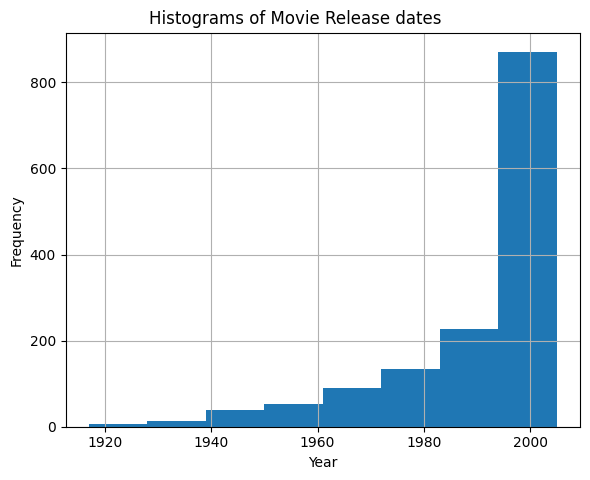

In [13]:
# Plot histogram with bins spanning 10 years
df['year'] = df['year'].astype(int)
plt.figure(figsize=(6, 5))
df['year'].hist(bins=int((df['year'].max() - df['year'].min()) / 10), figsize=(6, 5))
plt.suptitle('Histograms of Movie Release dates', y=0.95)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

Data is skewed, as most records are released during the 90s and 00s.

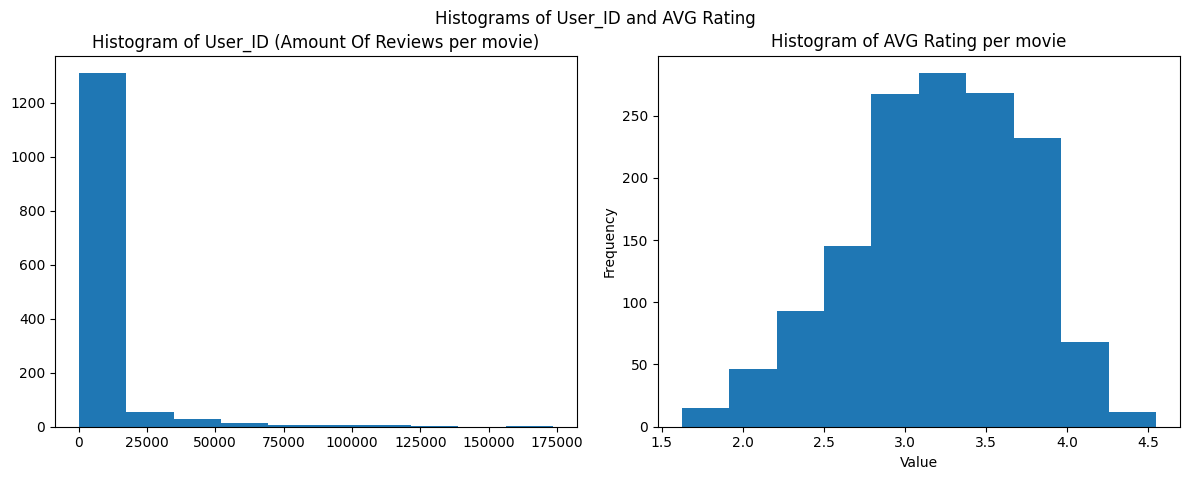

In [14]:
# Group by 'Movie_Title' and calculate count of User_ID and mean of Rating
result_df = review_df.groupby('Movie_Title').agg({'User_ID': 'count', 'Rating': 'mean'}).reset_index()

# Plot histograms for 'User_ID' and 'Rating'
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for 'User_ID'
axs[0].hist(result_df['User_ID'])
axs[0].set_title('Histogram of User_ID (Amount Of Reviews per movie)')

# Histogram for 'Rating'
axs[1].hist(result_df['Rating'])
axs[1].set_title('Histogram of AVG Rating per movie')

# Setting common attributes
plt.suptitle('Histograms of User_ID and AVG Rating', y=0.95)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

Amount of reviews is highly skewed, indicating lots of movies with low amounts to now reviews.

AVG Rating is normally distributed, meaning the ratings across movies in the dataset are normally deviating around the mean.

### **Outliers**

Outliers in amount of reviews and release date will not be removed, as they represent users connected to those movies. Those represent a real-world variability which cannot be excluded. 

Furthermore, robust recommender systems should be able to adapt to these outliers and represent valuable information to those users as well. Removing this information would also mean that the model cannot be trained on those.

As the user-item matrix will be sparse, removing outliers would further reduce the size of the data which the model can use to train, which would make it more challenging to build a reliable recommender system.

## Check for timeseries association with ratings:

Hypothese before doing ANOVA:

- **H0**: means of groups across months of the year are **equal**, meaning there **IS NO** correlation between the time of the year and the avg. rating.
- **Ha**: means of groups across months of the year are **NOT equal**, meaning there **IS** correlation between the time of the year and the avg. rating.

In [15]:
# force data into category format and change to month notation to compare months with avg rating
df_anova = review_df[['Date', 'User_ID', 'Rating', 'Movie_Title']]
df_anova['Date'] = (df_anova['Date'].dt.strftime('%B')).astype('category')

In [16]:
from scipy.stats import f_oneway

alpha = 0.05 # set confidence level at 95%

# Perform ANOVA
f_statistic, p_value = f_oneway(*[group['Rating'] for _, group in df_anova.groupby('Date')])

print("F-Statistic:", f_statistic)
print("P-value:", p_value)

if p_value < alpha:
    print("Not enough evidence to retain H0, so H0 will be dropped and Ha applies, meaning months of the year have significant correlation with the avg. reviews per movie.")
else:
    print("Enough evidence to retain H0, so H0 will be applied and Ha dropped, meaning months of the year DO NOT have significant correlation with the avg. reviews per movie.")

C:\Users\SJYHa\AppData\Local\Temp\ipykernel_15032\1331251935.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f_statistic, p_value = f_oneway(*[group['Rating'] for _, group in df_anova.groupby('Date')])


F-Statistic: 229.17093416907403
P-value: 0.0
Not enough evidence to retain H0, so H0 will be dropped and Ha applies, meaning months of the year have significant correlation with the avg. reviews per movie.


Check assumptions ANOVA:

In [17]:
from scipy.stats import shapiro, levene

# Get a random sample of 1000 observations from df_anova to get a accurate result in shaprio and levene test
sample_df = df_anova.sample(n=1000, random_state=42)

# Get residuals
residuals = []
for _, group in sample_df.groupby('Date'):
    residuals.extend(group['Rating'] - group['Rating'].mean())

# Shapiro-Wilk test for normality
_, shapiro_p_value = shapiro(residuals)
if shapiro_p_value > alpha:
    print("Residuals are normally distributed (normality assumption is met).")
else:
    print("Residuals are not normally distributed (normality assumption may be violated).")

# Levene's test for homogeneity of variances
levene_statistic, levene_p_value = levene(*[group['Rating'] for _, group in sample_df.groupby('Date')])
if levene_p_value > alpha:
    print("Variances of residuals are approximately equal across all groups (homogeneity of variances assumption is met).")
else:
    print("Variances of residuals are not equal across all groups (homogeneity of variances assumption may be violated).")

Residuals are not normally distributed (normality assumption may be violated).
Variances of residuals are approximately equal across all groups (homogeneity of variances assumption is met).


C:\Users\SJYHa\AppData\Local\Temp\ipykernel_15032\1507436444.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in sample_df.groupby('Date'):
C:\Users\SJYHa\AppData\Local\Temp\ipykernel_15032\1507436444.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene_statistic, levene_p_value = levene(*[group['Rating'] for _, group in sample_df.groupby('Date')])


In case assumptions are violated, perform kruskal wallis test:

In [18]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
kruskal_statistic, kruskal_p_value = kruskal(*[group['Rating'] for _, group in df_anova.groupby('Date')])

print("Kruskal-Wallis Statistic:", kruskal_statistic)
print("P-value:", kruskal_p_value)

alpha = 0.05 # Set confidence level at 95%
if kruskal_p_value < alpha:
    print("Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups. Therefore, there IS enough evidence to suggest month of the year has significant correlation with avg. rating.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to suggest that there are significant differences between the groups across months of the year. Therefore, there is NOT enough evidence to suggest month of the year has significant correlation with avg. rating.")


C:\Users\SJYHa\AppData\Local\Temp\ipykernel_15032\3374717359.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_statistic, kruskal_p_value = kruskal(*[group['Rating'] for _, group in df_anova.groupby('Date')])


Kruskal-Wallis Statistic: 2739.9313154129222
P-value: 0.0
Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups. Therefore, there IS enough evidence to suggest month of the year has significant correlation with avg. rating.


### Handle null values:

Already handled in the joining.ipynb file. There are no null values in the Netflix Prize Dataset to handle.